In [ ]:
import PIL
import numpy as np
from PIL import Image

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

In [ ]:
import numpy as np

In [ ]:
x_train=np.load('/content/x_128_train.npy')
x_test=np.load('/content/x_128_test.npy')
x_valid=np.load('/content/x_128_valid.npy')

In [ ]:
len(x_valid)

240

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


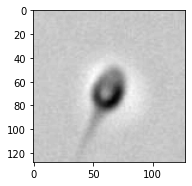

In [ ]:
for i in range(0, 10):
	plt.subplot(1,2,2)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
x_valid = tf.cast(x_valid, tf.float32)

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0,
    fill_mode='nearest',
    cval=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None)

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
y_train=np.load('/content/y_head_train.npy')
y_test=np.load('/content/y_head_test.npy')
y_valid=np.load('/content/y_head_valid.npy')

In [ ]:
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)
y_valid = tf.cast(y_valid, tf.float32)

In [ ]:
print(x_train.shape)  # (64, 224, 224)
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
print(x_train.shape)  # (64, 224, 224, 3)

(1000, 128, 128)
(1000, 128, 128, 3)


In [ ]:
print(x_test.shape)  # (64, 224, 224)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
print(x_test.shape)  # (64, 224, 224, 3)

(300, 128, 128)
(300, 128, 128, 3)


In [ ]:
print(x_valid.shape)  # (64, 224, 224)
x_valid = np.repeat(x_valid[..., np.newaxis], 3, -1)
print(x_valid.shape)  # (64, 224, 224, 3)

(240, 128, 128)
(240, 128, 128, 3)


In [ ]:
x_train = datagen.flow(x_train,y_train,batch_size=30)
x_valid = valid_datagen.flow(x_valid,y_valid,batch_size=30)
x_test= valid_datagen.flow(x_test,y_test,batch_size=30)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

In [ ]:

basemodel=ResNet50(weights='imagenet',include_top=False, input_tensor=Input(shape=(224,224,3)))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
basemodel.trainable=False

In [ ]:
x = basemodel.output
x = GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x = Dropout(0.3)(x)
x=Dense(128,activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation= 'sigmoid')(x)
model = Model(inputs = basemodel.input, outputs = predictions)

In [ ]:
from keras.optimizers import SGD, Adam

adam = Adam(lr=0.0001)

model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.input.shape


TensorShape([None, 224, 224, 3])

In [ ]:
# FOR checking
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

hist = model.fit(steps_per_epoch=34,x=x_train, validation_data= x_valid,epochs=2,callbacks=[checkpoint])


In [ ]:
model.load_weights('vgg16_1.h5')

In [ ]:
preds = model.evaluate(x_test,verbose=1)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
y_pred=model.predict(x_test)
for i in range(0,300):
  if y_pred[i]>0.5:
    y_pred[i]=1
  else:
    y_pred[i]=0

y_pred
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score ,f1_score, precision_score ,roc_auc_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred,average='macro'))
print(precision_score(y_test,y_pred,average='macro'))
print(recall_score(y_test,y_pred,average='macro'))
#print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test,y_pred,average='macro'))
#plot_confusion_matrix(model,x_test,y_test,values_format='d')
import itertools

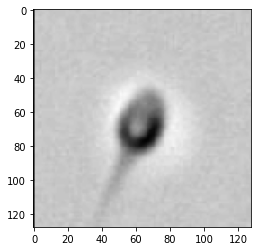

(1, 128, 128, 3)
Predicted class is: [[0.12202239]]


In [ ]:
from keras import models
from keras.preprocessing import image
img_path = '3.png'
img = image.load_img(img_path, target_size=(128, 128,32))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Predicted class is:",classes)

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:6]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 3)


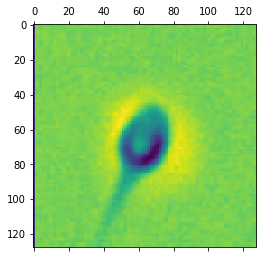

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


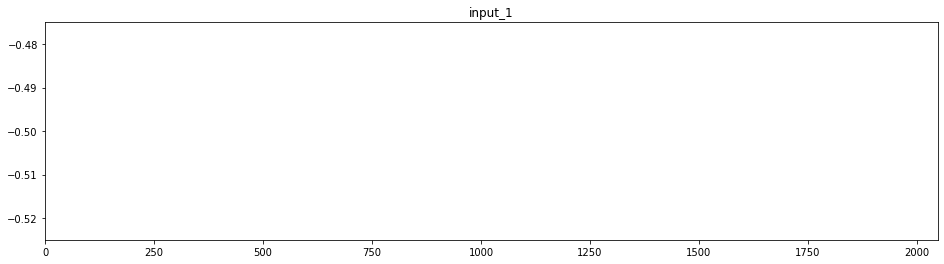

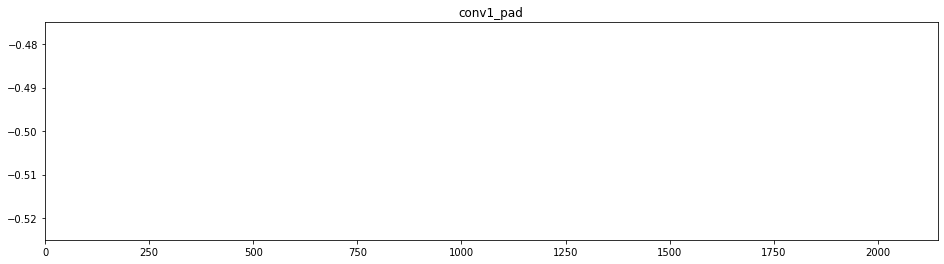

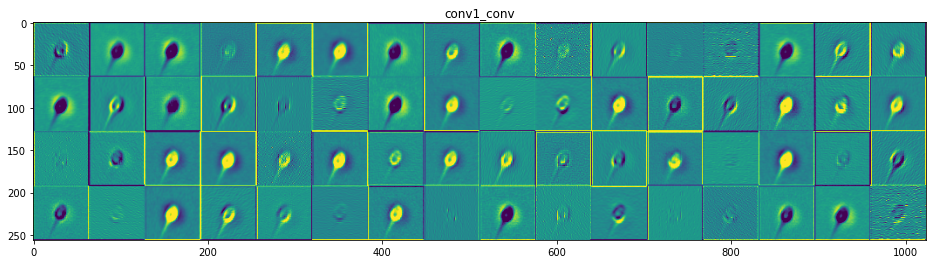

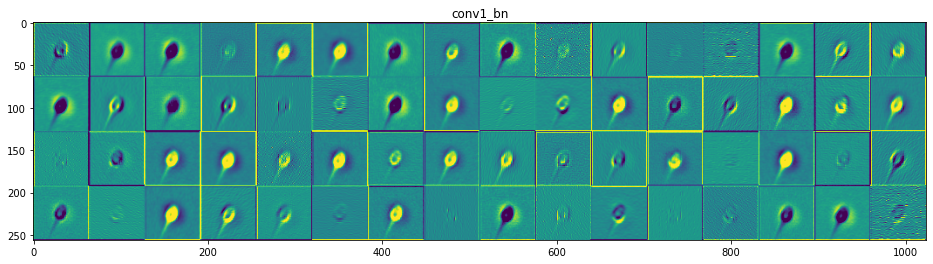

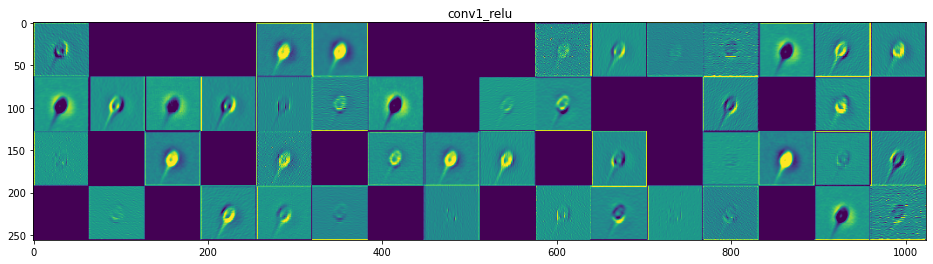

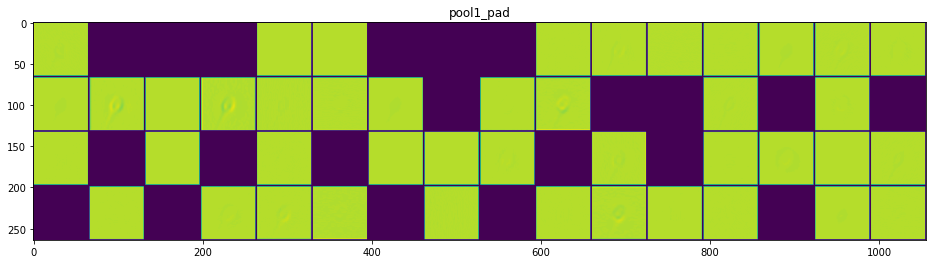

In [ ]:
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(16,4))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm=cm,classes=[0,1] ,title='Confusion Matrix')

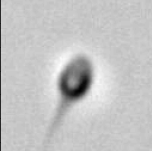

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv5_block3_3_conv"
classifier_layer_names = [
    "global_average_pooling2d",
    "flatten",
]

# The local path to our target image
#img_path = keras.utils.get_file(
 #   "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
#)

display(Image('/content/3.png'))


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



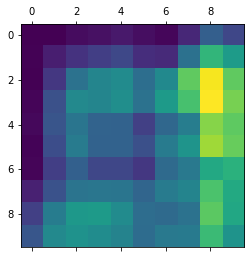

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array('/content/3.png', size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()


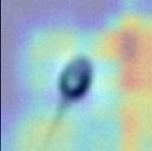

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img('/content/3.png')
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "acrosome.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))